## DSC 478 Assignment2_Part 1. KNN & Rocchio Method on NewsGroup

Xuyang Ji <br> Jan 31st, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
%matplotlib inline
# get rid of warning–>RuntimeWarning: divide by zero 
#encountered in true_divide in computing TF-IDF matrix 
import warnings 
warnings.filterwarnings("ignore")

### I. Data Preprocessing

The Newsgroup subset contains 1,000 documents, represented as bags of its words across 5,500 terms, with each value represent raw term occurance counts. The bag-of-words structure is used in methods of document classification including _**K-Nearest Neighbors**_ Method and _**Relevant Feedback**_, where the occurance of each word is used as a feature for training the classifiers. Each document belongs to one of the two classes, _**Hockey with class label 1**_ or _**Microsoft Windows with class label 0**_. The data has already been split into training and test data, detailed structure as follows. 


* train: The term-document frequency matrix for the train set, containing 5500 terms and 800 documents.


* test: The term-document frequency for the test set, containing 5500 rows and 200 columns.


* train_lab: The file contains the labels associated with each training document.The classId refers to one of the two classes and takes one of the values 0 (for Windows) or 1 (for Hockey).


* test_lab: This file contains the labels associated with each test document.


* terms: This file contains the set of 5500 terms in the vocabulary. Each line contains a term and corresponds to the corresponding rows in term-document frequency matrices. 


In [2]:
#Load datasets 
train = pd.read_table('trainMatrixModified.txt', header = None)
test = pd.read_table('testMatrixModified.txt', header = None)
train_lab = pd.read_table('trainClasses.txt', header = None,index_col = 0)
test_lab = pd.read_table('testClasses.txt', header = None, index_col = 0)
terms = pd.read_table('modifiedterms.txt', header = None)


#### I.a. Zipf Distribution in Training Data

By calculating the frequency that each word appears in the documents, _**subject**_ and _**window**_ are the top 2 most commonly presented words in the training dataset. The term frequency indicates that those two words are most significant within the overall document. As shown in the plot, the less frequent data are lumped together at the end of the frequency spectrum, where their frequency is not distinguishable and can mess up the classification algorithm. 

In [3]:
#Compute term frequencies across all documents in the training set 
#to get idea of term distributions
termFreqs = train.sum(axis=1)
tf= pd.DataFrame({'Count': termFreqs.values})
tf= tf.join(terms)
tf.sort_values(by="Count",ascending=False)

,Count,0
3,959.0,subject
225,720.0,window
136,680.0,game
1682,578.0,do
115,545.0,get
...,...,...
5335,1.0,retain
5324,1.0,brother
5319,1.0,graduat
5317,1.0,julia


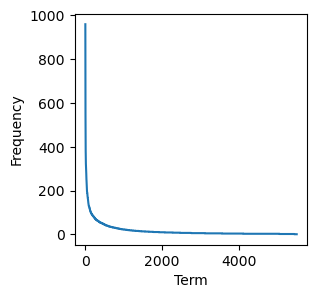

In [4]:
#plot the distribution
plt.rcParams['figure.figsize'] = [3, 3]
plt.plot(sorted(tf.Count, reverse=True))
plt.xlabel("Term")
plt.ylabel("Frequency")
plt.show()

#### I.b. Data Prepation 

In [5]:
# Process Term*Document dataframe to Document*Term matrix 
DT_train = np.array(train.T)
DT_test = np.array(test.T)

#Process training labels into array,
#return a copy of array collapsed into 1 dimension 
train_lab_array= np.array(train_lab).flatten()
test_lab_array= np.array(test_lab).flatten()

### II.  K-Nearest-Neighbor Algorithm 

The KNN method classify a new instance by finding the training documents that are nearest to the new instance, and assign the instance to the most frequently occuring class. 

#### II.a. KNN Search & KNN Classify Function

The _**knn_search**_ function takes as input the training data matrix,  the instance to be classified, the value of K (number of neighbors), and the distance metric method; and return the indices of the top K neighbors and the inverse of Cosine Similarity or Euclidean Distance from the top K neighbors. 

The  _**knn_classify**_ function takes as input the training data matrix, the training labels, the instance to be classified, the value of K (number of neighbors), and the distance metric method; and return the label associated with the highest number of count among the neighbors, and the indices of nerighbors. 

In [6]:
def knn_search(x, D, K, measure):
    """Finding K-nearest neighbors of an instance x among the 
    instances in document*term matrix D,using Euclidean distance or Cosine dissimilarity"""
    if measure == 0:
        # Using Euclidean distances between instance x and other points in D
        dist = np.sqrt(((D-x)**2).sum(axis=1))
    elif measure ==1:
        # Using Cosine distance 
        # First finding the vector L2-norm for each instance in D and for x
        D_norm = np.array([np.linalg.norm(D[i])for i in range(len(D))])
        x_norm= np.linalg.norm(x)
        #Compute Cosine Similarity sim(D,x) with function call 
        sim= np.dot(D,x)/(D_norm*x_norm)
        dist= 1-sim
    #sorting distances in ascending order, return an array of indices 
    idx= np.argsort(dist)
    #Return the indice of the top K neighbors
    return idx[:K],dist

def knn_classify(x, D, K, terms, measure):
    """Identifying the label for x, using the majority label of the K nearest neignbors """
    from collections import Counter 
    # Getting K nearest neighbors distances&indexes
    neighbor_idx, distances= knn_search(x, D, K, measure)
    #Getting neighbors labels 
    neighbor_term = terms[neighbor_idx]
    #return indexes as dict keys and their counts as dict values 
    count= Counter(neighbor_term)
    #return one label associated with the highest number of count
    category= count.most_common(1)[0][0]
    return neighbor_idx, category
    

In [7]:
##KNN Classifier test of measure 1

top_K_neighbors, predicted_category = knn_classify(DT_test[12],DT_train,10,train_lab_array,1)
print("The indices of KNN are:{}\nThe predicted class is: {}".format(top_K_neighbors,predicted_category))


The indices of KNN are:[334 177 233 715 732 510 221 178  94 254]
The predicted class is: 1


In [8]:
##KNN Classifier test of measure 0

top_K_neighbors, predicted_category = knn_classify(DT_test[12],DT_train,10,train_lab_array,0)
print("The indices of KNN are:{}\nThe predicted class is: {}".format(top_K_neighbors,predicted_category))


The indices of KNN are:[798 757 119 398  38 224 711 615 751  69]
The predicted class is: 0


#### II.b. K-Nearest-Neighbor Classifier Evaluation Function 

To measure the accuracy of the above KNN classifier, the following _**knn_evaluate**_ function call the classifier function on all the test instances, and in each case compares the actual test class label in test_lab to the predicted class label. The function take as input the training data, the training labels, the test labels, the distance measure, and the value of K; and return the Classification Accuracy. 

In [9]:
def knn_evaluate(test, test_lab, train, train_lab, K, measure):
    """iterates through documents in test set, and for each instance, calls 
    knn_classify to predict the label. It compares the predicted label vs. actual label,
    And return the classification accuracy rate"""    
    correct=0
    for i in range(len(test)):
        predicted_test = list(knn_classify(test[i], train, K, train_lab, measure))
        category = predicted_test[1]
        if category == test_lab[i]:
                correct +=1
    accuracy_ratio = correct/float(len(test))
    return accuracy_ratio
    print("The classification accuracy rate is: ", accuracy_ratio)
    

In [10]:
test_accuracy= knn_evaluate(DT_test, test_lab_array, DT_train ,train_lab_array,5,0)
test_accuracy

0.815

#### II.c  Applying KNN Evaluate Function 

In order to compare accuracy values for different numbers of neighbors, the evaluation function would be run on a range of values for K from 5 to 100, with an increments of 5, for both Euclidean Distance and Cosine similarity measure. Based on the plot, with K in the x-axis and accuracy on the y-axis,the classifer using Cosine Similarity has a much higher accuracy ratio, compared to the one using Euclidean Distance, with a _**highest accuracy of 98.5% with K_value set at 10 and 15**_. 

On the other hand, the _**highest accuracy with Euclidean Distance is 85% with K_value set at 10**_. Looking at the plot trend, the quality of the classifer constantly decreases with the increasing amounts of neighbors, when k_value is greater than 10. Meantime, the quality of the classifer using Cosine Similarity is stable regardless of the K factor value. 

The reason behind the outperforming Cosine Similarity is that while the Euclidean Distance measure the distance between numerical values, the Cosine Similarity examine the angle between document vectors, _**without taking its weight or magnitude into consideration**_. Since the document datasets contains documents of uneven lengths, the Cosine Similarity is more suitable to work with text data represented by word frequency.

In [11]:
Euclid=[]
for K in range(5,100,5):
    Euclid.append(knn_evaluate(DT_test, test_lab_array, DT_train, train_lab_array, K, 0))

In [12]:
Cosine=[]
for J in range(5,100,5):
    Cosine.append(knn_evaluate(DT_test, test_lab_array, DT_train, train_lab_array, J, 1))

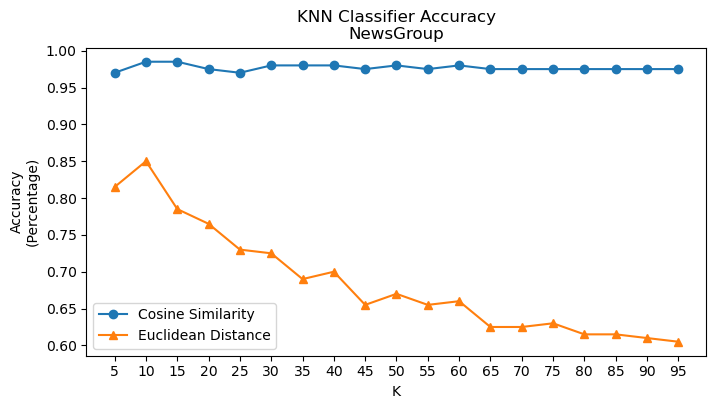

In [13]:
x= range(5,100,5)
fig,ax=plt.subplots(figsize=(8,4))
ax.plot(x,Cosine,marker="o",label="Cosine Similarity",)
ax.plot(x, Euclid, marker="^",label="Euclidean Distance")
ax.set(title = "KNN Classifier Accuracy\nNewsGroup",
       xlabel = "K",
       ylabel = "Accuracy\n(Percentage)")
ax.legend()
plt.xticks(np.arange(5,100,step=5))
plt.show()

#### II.d. Applying KNN Evaluate Function with TF-IDF weighted value

To deal with the Zipf distribution problem, _**Term Frequency*Inverse Document Frequency**_ is applied. The method weights terms highly if they are frequent in the trainng document but infrequent in the whole collection, while providing low values for common words in the collection. 

The _**train_weight and test_weight**_ contains weighted value of each searched document, presented as a multi-dimensional array, with a dimension defined by _**Document*Term**_. Each row corresponds to one of the document and each column corresponds to one term, and the (i,j)th element of the matrix shows the frequency of the jth term in the ith document.

In [14]:
#Transform data to TF-IDF weights 
## Finding doc counts for each term 
DF_train= pd.DataFrame([(train!=0).sum(1)]).T
NDoc_train = np.ones(np.shape(train),dtype=float)*(train.shape[1])
np.set_printoptions(precision=2,suppress=True,linewidth=120)
IDF_train= np.log2(np.divide(NDoc_train,np.array(DF_train)))

tfidf_train = train* IDF_train
pd.set_option("display.precision", 2)

#KNN function expects a Document*Term Matrix as an np.array
train_weight= np.array(tfidf_train.T)
print(train_weight.shape)
tfidf_train.head()

(800, 5500)


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,8.00,0.00,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,13.67,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.51,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,12.64,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,23.11,2.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.78,0.0,0.0,0.0,0.0,0.0,0.0,2.89


In [15]:
DF_test= pd.DataFrame([(test!=0).sum(1)]).T
NDoc_test = np.ones(np.shape(test),dtype=float)*(test.shape[1])
np.set_printoptions(precision=2,suppress=True,linewidth=120)
IDF_test= np.log2(np.divide(NDoc_test,np.array(DF_test)))

#Patch the hole of inf with 1
IDF_test[(IDF_test == np.inf)|(IDF_test == 0)]=1
IDF_test.all()

tfidf_test = test* IDF_test
pd.set_option("display.precision", 2)
tfidf_test.head()

#KNN function expects a Document*Term Matrix as an np.array
test_weight= np.array(tfidf_test.T)
print(test_weight.shape)
tfidf_test.head()

(200, 5500)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,3.74,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.00,1.0,1.0,1.0,2.0,1.0,1.00,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,5.89,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The resulting of testing text classification quality with using TF_IDF weight is shown below, the plot directly indicates the necessity of using weighted value. By using the weighted Cosine Similarity metric, _**the most optimal accuracy rate at 100% using 40 neighbors**_. 

The idea behind the TF-IDF is to dampen the effect of high-frequency words in determing the importance of a document, which allows the determination of weight for each term in each document. The _**importance of the term is increased proportionally to the number of appearing in the documents**_. Hence, the combination of KNN algorithm and TF-IDF method has been shown as a better choice in the implementation. 

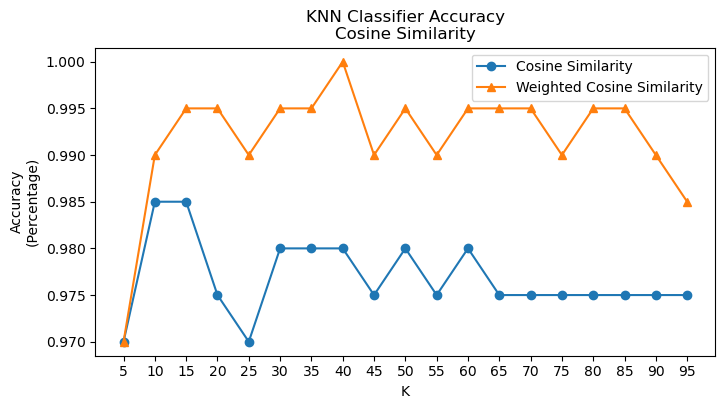

In [16]:
Cosine_weight=[]
for P in range(5,100,5):
    Cosine_weight.append(knn_evaluate(test_weight, test_lab_array, train_weight, train_lab_array, P, 1))

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(x,Cosine,marker="o",label="Cosine Similarity",)
ax.plot(x, Cosine_weight, marker="^",label="Weighted Cosine Similarity")
ax.set(title = "KNN Classifier Accuracy\nCosine Similarity",
       xlabel = "K",
       ylabel = "Accuracy\n(Percentage)")
ax.legend()
plt.xticks(np.arange(5,100,step=5))
plt.show()

### III. Nearest Centroid Algorithm - Rocchio Method

The goal of the local method for relevance feedback, _**Rocchio Method**_ is to adjust a query relative to more closely match the optimal query by maximizing similarity with relevant document, and minimizing similarity with irrelevant ones. 

#### III.a. Training the Rocchio Method

Adapting for text categorization, the _**Rocchio_Train**_ function takes as input the training data matrix and the training labels, returning the prototype vectors for each class by summing the vector, and the tfidf value for each document term entry. 

In [17]:
def Rocchio_Train(train, train_lab):
    train_lab.rename(columns={train_lab.columns[0]:"Class_label"},inplace=True)
    prototype= pd.concat([train.T, train_lab],axis=1)
    #Using list comprehension to return a list of dataframes, with one dataframe for each state.
    df_list = [prototype for _, prototype in prototype.groupby(['Class_label'])]
    
    #Store in a dictionary
    class_dict= {}
    
    for i in range(len(df_list)):
        class_dict[i]=pd.DataFrame(df_list[i].drop(columns="Class_label"))
    
    IDF_array=[]
    for i in range(len(class_dict)):
        DocCountTerm= pd.DataFrame([(class_dict[i]!=0).sum(0)])
        
        ##Creatring a matrix with all entries== the number of documents in class[i]
        ##DMatrix's structure = 5500Terms* 401Docs 
        DMatrix=np.ones(np.shape(class_dict[i].T), dtype=float)*class_dict[i].T.shape[1]
        np.set_printoptions(precision=2,suppress=True,linewidth=120)
        
        ##Convert entry into log of the inverse of document frequency
        IDF_dic= np.log2(np.divide(DMatrix,np.array(DocCountTerm.T)))
        IDF_dic[(IDF_dic==np.inf)|(IDF_dic==0)]=1
        IDF_array.append(IDF_dic)
        ##Compute tfidf value for each document term entry
        ##Terms*Documents 
        class_dict[i]= class_dict[i].T*IDF_dic
    
    #prototype is the dictionary with unique class labels as keys and 
    #one dimensional arrays representing the prototype vectors for the class as values
    prototype_class={}
    for i in range(len(class_dict)):
        pclass= np.array(np.sum(class_dict[i],axis=1))
        prototype_class.update({i:pclass})

    return prototype_class, IDF_array


#### III.b. Rocchio Classifier Function

The _**Rocchio_Classify**_ function take as input the training data matrix and the training labels,which later return prototypes for each class, and the new instance to be classified. The function assign the new instance to the class with the closet prototype vector based on Cosine Similarity. The function output indicate the predicted class for the test instance, in accorance with the region it falls into and the centrold that the new instance is closet to; and the similarity values of the instance to each of the category prototypes.  

In [18]:
from numpy.linalg import norm

def Rocchio_Classify(train,train_lab,instance):
    prototype_class, IDF_array= Rocchio_Train(train, train_lab)

    #Let init.maximum cosSim be -2 and init.preicted_label as -1(non-existence)
    predicted_label= -1
    cosSim_max = -2
    
    #Compute similarity to prototype vector with function cosine=np.dot(instance_tfidf,prototype[i])/
    #norm(instance_tfidf)*norm(prototype[i])
    i=0
    for key,value in prototype_class.items():
        # Each term in query must be multiplied by the idf value of the term 
        instance_tfidf= instance.T*((IDF_array[i].T)[0])
        instance_tfidf= np.array(instance_tfidf)
        cosSim = np.dot(instance_tfidf, value)/(norm(instance_tfidf)*norm(value))
        if cosSim > cosSim_max:
            cosSim_max = cosSim
            predicted_label= key
        i +=1
    return predicted_label, cosSim_max


In [19]:
##Rocchio Classifier test of for instance test[3]

predicted_label, cosSim_max = Rocchio_Classify(train,train_lab,test[3])
print("The predicted class is:{}\nThe Cosine Similarity is: {}".format(predicted_label, cosSim_max))

The predicted class is:1
The Cosine Similarity is: 0.23916517634671772


#### III.c. Rocchio Evaluate Function

The _**Rocchio_Evaluate**_ function take as input the training data matrix and the training labels,which later return prototypes for each class, testing data matrix, and the test label; and returns the accuracy ratio of the Rocchio classifer. By using the centroids for each class to define the boundaries, the Rocchio classifer returns a 98.5% accuracy rate. 

In [20]:
def Rocchio_Evaluate(train, train_lab,test,test_lab):
    accuracy=0
    test_lab_array= np.array(test_lab).flatten()
    DT_test = np.array(test.T)
    for i in range(len(DT_test)):
        predicted_label, CosSim = Rocchio_Classify(train, train_lab, DT_test[i])
        if predicted_label == test_lab_array[i]:
            accuracy+=1
    accuracy_ratio= accuracy/float(len(test_lab))
    return accuracy_ratio
            

Rocchio_Evaluate(train,train_lab,test, test_lab)

0.985

#### III.d. Rocchio Classifer vs. kNN Classifier

Based on the plot, the most optimal kNN classifer outperforms the Rocchio classifer by approximately 1.5%, while with constantly better accuracy rate regardless of the number of K. While the dataset is large and the classes may not be linearly separable, kNN can handle complex classes better than Rocchio. Hence, the Rocchio classifer has a high bias and low variance regarding the algorithm rule; while the kNN classifer has a low bias and high variance. 

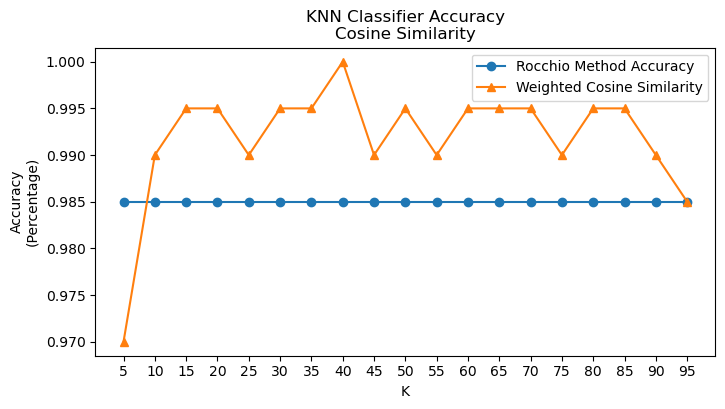

In [21]:
Rocchio_accuracy= [0.985]*19
Cosine_weight=[]
for P in range(5,100,5):
    Cosine_weight.append(knn_evaluate(test_weight, test_lab_array, train_weight, train_lab_array, P, 1))

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(x,Rocchio_accuracy,marker="o",label="Rocchio Method Accuracy",)
ax.plot(x, Cosine_weight, marker="^",label="Weighted Cosine Similarity")
ax.set(title = "KNN Classifier Accuracy\nCosine Similarity",
       xlabel = "K",
       ylabel = "Accuracy\n(Percentage)")
ax.legend()
plt.xticks(np.arange(5,100,step=5))
plt.show()

#### III.e scikit-learn vs. Rocchio Classifer 

The value of 0 indicates the _**Microsoft Windows**_class, whereas the value of 1 indicates _**Hockey**_ class. Based on precision with using the NearestCentroid classifer, out of all documents identified as Hockey, _**89%**_ of them actually are. Based on the recall value, out of all documents actually labeled as Microsoft Window class, _**the model predicted correctly for 88% of those documents**_. Finally, the value of 0.94 in f1-score indicates the model has a _**94% accuracy rate**_. Comparing to the accuracy rate of 98.5% for Rocchio Classifer, NearestCentroid method in sklearn performs slightly less accurate, since the scikit-learn method does not use TF-IDF weighted value by default. 

In [22]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
model= NearestCentroid()
model.fit(DT_train, train_lab_array)

# Printing classification report of classifier on the test set set data
print(
    f"Model Classification Report : \n{classification_report(test_lab_array, model.predict(DT_test))}")

Model Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        99
           1       0.89      1.00      0.94       101

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

